In [1]:

import gpytorch
from matplotlib import pyplot as plt
%matplotlib widget
import numpy as np
import sys, os
os.environ['MKL_DEBUG_CPU_TYPE'] = '5'
sys.path.append('/Users/naji/phd_codebase/psych_model/utils')
sys.path.append('/Users/naji/phd_codebase/psych_model/puLearning')
sys.path.append('/Users/naji/phd_codebase/psych_model/LPUModels')
sys.path.append('/Users/naji/phd_codebase/')


import sklearn.model_selection 
import sklearn.datasets
import torch
import gpytorch.distributions
import lpu.constants as constants
import lpu.datasets.animal_no_animal.animal_no_animal_utils as animal_no_animal_utils
torch.autograd.set_detect_anomaly(True)


dtype = constants.DTYPE#torch.float64
torch.set_default_dtype(dtype)


import math_utils 
import dataset_utils  
import lpu.models.PsychM.psychm as psychm
# import visualization

    
EPSILON = 1e-16
COORDINATE_DESCENT = False
INDUCING_POINTS_SIZE = 64
LEARNINIG_RATE = .005
BATCH_SIZE = 32

DEVICE = 'cpu'
NUM_EPOCHS = 25
EPOCH_BLOCKS = 1
INTERVAL_LENGTH = 32

INTRINSIC_KERNEL_PARAMS = {'normed': False, 'kernel_type': 'laplacian', 'heat_temp': .01, 'noise_factor': .0, 
                        'amplitude': .5, 'n_neighbor': 5, 'lengthscale': .3, 'neighbor_mode': 'distance',
                        'power_factor': 1, 'invert_M_first': False}

TRAIN_TEST_RATIO = 0.5
DATASET = 'animal_no_animal'



In [2]:
if DATASET == 'synthetic':
    N_SAMPLES = 300
    X_y_SAMPLE_TYPE = 'circles'

    if X_y_SAMPLE_TYPE == 'circles':
        # CIRCLES AS SAMPLE
        X, y = sklearn.datasets.make_circles(n_samples=N_SAMPLES, factor=.5,
                                                noise=.05)
    #     y = 1 - y
    elif X_y_SAMPLE_TYPE == 'moons':
        X, y = sklearn.datasets.make_moons(n_samples=N_SAMPLES, noise=.05)
    elif X_y_SAMPLE_TYPE == 'rbf_kernel':
        X = np.random.randn(N_SAMPLES *2).reshape((-1, 2))
        phi_X = math_utils.modified_rbf_kernel(X)
        alpha = np.random.randn(N_SAMPLES)
    l_mean = 0
    y_l_mean = 0
    y_l_sum = 0
    counter = 0
    while  y_l_sum < 5 or y_l_sum > 10:
        # print (y_l_sum)
        sig_X, sig_y, sig_l, real_params = dataset_utils.create_synthetic_dataset(X, y, dim=2, sample_size=0, initial_lambda_range=[0.1, .03], initial_gamma_range=[0.0, .05])
        if counter and np.mod(counter, 1000)==0:
            print ("still struggling with dataset_utils.create_synthetic_dataset()... and counter is:", counter, y_l_sum)
        y_l_sum = sig_l[sig_y==1].sum()
        l_mean = sig_l.sum()
        counter += 1
    psych_X, psych_y, psych_l = sig_X, sig_y, sig_l
    y = sig_y
    l = sig_l
elif DATASET == 'swissprot':
    X, y, l = dataset_utils.read_swissprot('/Users/naji/Downloads/swissprot.data/', embedding='TF-IDF')
    sig_X, sig_y, sig_l = X, y, l
    psych_X, psych_y, psych_l = X, y, l
elif DATASET == 'animal_no_animal':
    output_location = f'{constants.ROOT_PATH}/datasets/animal_no_animal'
    subject = 'mta'
    model_type = 'vgg'  # or 'HMAX'
    layers_to_extract = ['classifier_0']
    X, y, l = animal_no_animal_utils.create_animal_no_animal_dataset(output_location=output_location, subject=subject, model_type=model_type, layers_to_extract=layers_to_extract)
    sig_X, sig_y, sig_l = X, y, l
    psych_X, psych_y, psych_l = X, y, l

# Assuming sig_X, psych_X, y, and l are defined somewhere above
# encoder = sklearn.preprocessing.LabelEncoder()
l_y_cat_transformed = 2 * l.astype(int) + y.astype(int)

# Splitting the data
train_indices, test_indices, sig_X_train, sig_X_test, psych_X_train, psych_X_test, y_train, y_test, l_train, l_test, l_y_cat_transformed_train, l_y_cat_transformed_test = sklearn.model_selection.train_test_split(
    np.arange(len(sig_X)), sig_X, psych_X, y, l, l_y_cat_transformed, stratify=l_y_cat_transformed, test_size=TRAIN_TEST_RATIO, shuffle=True
)


/Users/naji/miniconda3/envs/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/naji/miniconda3/envs/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layers to be extracted are ['classifier_0']


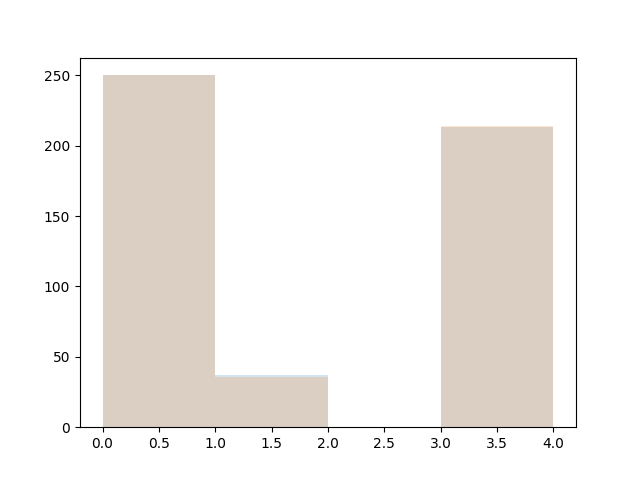

In [3]:
fig, ax = plt.subplots()
ax.hist(l_y_cat_transformed_train, bins=[0, 1 , 2, 3, 4], alpha=0.2)
ax.hist(l_y_cat_transformed_test, bins=[0, 1, 2, 3, 4], alpha=0.2)
plt.show()


In [4]:
# sample = dict()
# fig = visualization.plot_all_four(sig_X, l ,y, real_params)
# true_gamma, true_lambda, _, _, true_alpha, true_beta = real_params
# true_alpha, true_beta

In [5]:
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
# Normalize sig_X_train and psych_X_train, and use the same statistics to normalize sig_X_test and psych_X_test
sig_X_mean = sig_X_train.mean(axis=0)
sig_X_std = sig_X_train.std(axis=0)
psych_X_mean = psych_X_train.mean(axis=0)
psych_X_std = psych_X_train.std(axis=0)

# Prevent division by zero
sig_X_std[sig_X_std == 0] = 1
psych_X_std[psych_X_std == 0] = 1

# Normalizing data
sig_X_train = (sig_X_train - sig_X_mean) / sig_X_std
sig_X_test = (sig_X_test - sig_X_mean) / sig_X_std
psych_X_train = (psych_X_train - psych_X_mean) / psych_X_std
psych_X_test = (psych_X_test - psych_X_mean) / psych_X_std


sig_X = (sig_X - sig_X_mean) / sig_X_std
psych_X = (psych_X - psych_X_mean) / psych_X_std

# Structuring the data
data = {
    "full":
        {"sig_X": sig_X,
        "psych_X": psych_X,
        "y": y,
        "l": l},

    "train": {
        "sig_X": sig_X_train,
        "psych_X": psych_X_train,
        "y": y_train,
        "l": l_train
    },
    "test": {
        "sig_X": sig_X_test,
        "psych_X": psych_X_test,
        "y": y_test,
        "l": l_test
    }
}




# Convert all datasets in the dictionary to PyTorch tensors
for split in ["train", "test", "full"]:
    for key in data[split]:
        data[split][key] = torch.tensor(data[split][key], dtype=constants.DTYPE).to(DEVICE)  # Use torch.float32 if your model expects float32

# Assuming normalization has been done as per your provided code

# Convert all datasets in the dictionary to PyTorch tensors and create DataLoaders
dataloaders = {}


In [6]:
X.shape

(1000, 4096)

In [7]:
# data = {a
#         "sig_X": torch.tensor(sig_X),
#         "psych_X": torch.tensor(psych_X),
#         "y": torch.tensor(y),
#         "l": torch.tensor(l)}


In [8]:
# print("SAD")

In [9]:
inducing_points = sklearn.model_selection.train_test_split(data['train']['sig_X'], train_size=INDUCING_POINTS_SIZE, random_state=42, stratify=data['train']['l'])[0]


In [10]:
# import ElkanGGPC
# elkan_ggpc = ElkanGGPC.ElkanGGPC(intrinsic_kernel_params=INTRINSIC_KERNEL_PARAMS)
# elkan_ggpc.fit(data['train']['sig_X'], data['train']['l'])
# my_fig = visualization.plot_all_four(sig_X_train[:, :2], l_train_train_tensor , y_train, real_params)


In [11]:


import sklearn.metrics
# likelihood.cholesky_factor_a.register_hook(print_grad)
# mll =gpytorch.mlls.PredictiveLogLikelihood(likelihood, gp_model, num_data=len(data['train']['sig_X'])).to(DEVICE)
# mll = gpytorch.mlls.DeepApproximateMLL(gpytorch.mlls.VariationalELBO(likelihood, gp_model, num_data=600)).to(DEVICE)
# def validate(model, likelihood, validation_x, validation_y, validation_l):
#     # Set model and likelihood in evaluation mode
#     # model.eval()
#     # likelihood.eval()
#     # X = likelihood.X
#     with torch.no_grad():
#         validation_output = model(validation_x)
#         likelihood.update_input_data(validation_x)
#         # Assuming using negative log likelihood as validation metric
#         validation_loss = -mll(validation_output, validation_l)# - validation_output.log_prob(validation_y).item()
#         torch.where((validation_y > 0) & (validation_y < EPSILON), torch.tensor(EPSILON, device=validation_y.device), validation_y)

#         predicted_output = torch.sigmoid(validation_output.mean).cpu().numpy()
#         validation_auc = sklearn.metrics.roc_auc_score(validation_y.cpu().numpy(), predicted_output)
#     # validation_output.mean
#     # Return model to training mode
#     # likelihood.update_input_data(X)
#     # model.train()
#     # likelihood.train()

#     return validation_loss, validation_auc



In [12]:
validation_x = data['test']['sig_X'].to(DEVICE)  # Validation inputs
validation_y = data['test']['l'].to(DEVICE)  # Validation labels



In [13]:
# def compute_custom_loss(output, labels):
#     # Assuming the likelihood's forward method returns a distribution
#     # preds = likelihood(model_output).mean  # Get the mean predictions
#     # samples = likelihood.function_samples
#     # samples = output.rsample(torch.Size([10]))  # Sample 10 times
#     # print(samples.shape, labels.shape)
#     # Filter outputs where labels are 1 (positive instances)

#     positive_outputs = output.mean[labels == 1]
#     # Clamp positive values that are smaller than EPSILON to be EPSILON
#     # This leaves negative values and positive values >= EPSILON unchanged
#     torch.where((positive_outputs > 0) & (positive_outputs < EPSILON), torch.tensor(EPSILON, device=positive_outputs.device), positive_outputs)

#     positive_preds = torch.nn.functional.logsigmoid(positive_outputs)
#     custom_loss = positive_preds.mean()  
#     # output = output.mean[(labels == 1)]
#     # output[output > 1] = 1
#     # output[output < EPSILON] = EPSILON
#     # positive_preds = torch.nn.functional.logsigmoid()    # print(samples)
#     # positive_preds = samples[labels == 1]  # Filter predictions for positive instances
#     # print (samples.shape, positive_preds.shape, labels.shape, (labels==1).sum())
#     # custom_loss = positive_preds.mean()
#     # custom_loss = torch.clamp(custom_loss, min=EPSILON)
#     return -custom_loss  # Return the negative log likelihood

In [14]:
from torch.utils.data import Sampler
class StratifiedSampler(Sampler):
    """Stratified Sampling without replacement."""
    def __init__(self, labels):
        self.num_samples = len(labels)
        self.class_vector = np.array(labels).astype(int)
        self.indices = np.arange(self.num_samples)
        
    def __iter__(self):
        # Find the unique classes and their respective counts
        class_counts = np.bincount(self.class_vector)
        class_indices = [np.where(self.class_vector == i)[0] for i in range(len(class_counts))]
        
        # Calculate the number of items per class in each batch
        n_batches = self.num_samples // len(class_counts)
        indices = []
        for _ in range(n_batches):
            for class_idx in class_indices:
                indices.append(class_idx[np.random.randint(len(class_idx))])
        np.random.shuffle(indices)
        
        # In case the total number of samples isn't divisible by the number of classes,
        # randomly select the remaining indices
        remainder = self.num_samples - len(indices)
        if remainder:
            extra_indices = np.random.choice(self.indices, size=remainder, replace=False)
            indices = np.concatenate([indices, extra_indices])
        
        assert len(indices) == self.num_samples
        return iter(indices)

    def __len__(self):
        return self.num_samples

In [16]:
# tune

In [17]:
clf = psychmGP()


In [18]:
clf.fit(sig_X_train, l_y_cat_transformed_train)

inducing_points.shape: torch.Size([64, 4096])
True alpha:  0
True beta:  0
Iteration 0: Training loss = 15.321166306415604, Validation loss = None, Validation AUC = None. Elapsed time: 5.477503061294556s,  beta:Parameter containing:
tensor(-0.0160, requires_grad=True)
Iteration 1: Training loss = 16.571284657432717, Validation loss = None, Validation AUC = None. Elapsed time: 5.231953144073486s,  beta:Parameter containing:
tensor(-0.0338, requires_grad=True)
Iteration 2: Training loss = 15.058013612421943, Validation loss = None, Validation AUC = None. Elapsed time: 5.375159978866577s,  beta:Parameter containing:
tensor(-0.0309, requires_grad=True)
Iteration 3: Training loss = 14.590481501192903, Validation loss = None, Validation AUC = None. Elapsed time: 5.3964409828186035s,  beta:Parameter containing:
tensor(-0.0370, requires_grad=True)
Iteration 4: Training loss = 13.542254718756649, Validation loss = None, Validation AUC = None. Elapsed time: 5.113828897476196s,  beta:Parameter co

SKLearnCompatibleGP()

In [19]:
# validation_x = data['test']['sig_X'].to(DEVICE)  # Validation inputs
# validation_y = data['test']['y'].to(DEVICE)  # Validation labels
# validation_l = data['test']['l'].to(DEVICE)  # Validation labels

In [20]:
clf.gp_model.eval()
GP_clf_score = sklearn.metrics.roc_auc_score(y_test, clf.gp_model(torch.tensor(sig_X_test, dtype=constants.DTYPE)).mean.detach().numpy())

In [21]:
GP_clf_score

0.981232

In [22]:
# train_val_ratio = .5
# if train_val_ratio:
#     # Split data and create DataLoaders for training and validation
#     train_indices, val_indices, X_train, X_val, l_train, l_val = sklearn.model_selection.train_test_split(
#     np.arange(len(X)), X, l, stratify=l_y_cat_transformed, test_size=train_val_ratio, shuffle=True)
#     train_sampler = SubsetRandomSampler(train_indices)
#     val_sampler = SubsetRandomSampler(val_indices)
# else:
#     # Use entire dataset for training
#     X_train, l_train = X, l
#     train_indices = np.arange(len(X))
#     val_indices = []
# if not type(X_train) == 'torch.Tensor':
#     # Convert X, y to torch tensors
#     X_train_tensor = torch.tensor(X_train, dtype=constants.DTYPE).to(DEVICE)
#     l_train_tensor = torch.tensor(l_train, dtype=constants.DTYPE).to(DEVICE)

# # Create a TensorDataset
# dataset = TensorDataset(X_train_tensor, l_train_tensor)


# dataloaders = {}
# # if no validation set, use the StratifiedSampler
# if not train_val_ratio:
#     # Create an instance of the StratifiedSampler
#     train_sampler = StratifiedSampler(l_train)
# else:
#     dataloaders["val"] = DataLoader(dataset, batch_size=BATCH_SIZE,  sampler=val_sampler)

# dataloaders["train"] = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

# # Initialize model, likelihood, optimizer, and inducing points
# X_train_tensor = dataloaders['train'].dataset.tensors[0]  # Assuming the first tensor is your training data
# # inducing_points = self._initialize_inducing_points(X_train_tensor)


In [23]:
# import torch
# import gpytorch
# import matplotlib.pyplot as plt
# import numpy as np
# import time
# import copy
# import old_matrix_utils
# CUSTOM_LOSS_WEIGHT = 0.

# inducing_points = torch.tensor(sig_X_train[:INDUCING_POINTS_SIZE], dtype=constants.DTYPE).to(DEVICE)  # For example, take the first 50 data points as inducing points

# gp_model = psychm.VariationalGPModel(inducing_points=inducing_points, intrinsic_kernel_params=INTRINSIC_KERNEL_PARAMS).to(DEVICE)
# # Use the Adam optimizer
# # print (gp_model.)
# likelihood = psychm.CustomLikelihood(inducing_points.shape[1], torch.tensor(sig_X_train, dtype=constants.DTYPE),  is_SPM=False).to(DEVICE)
# optimizer = torch.optim.Adam([
#     {'params': gp_model.parameters()},  # Includes GP hyperparameters
#     {'params': likelihood.parameters()},  # Includes parameters a and b
# ], lr=LEARNINIG_RATE)#, nesterov=True, momentum=.9, weight_decay=1e-5)
# mll =gpytorch.mlls.PredictiveLogLikelihood(likelihood, gp_model, num_data=len(sig_X_train), beta=1).to(DEVICE)

# # Use VariationalELBO

# # Setup
# if DATASET == 'synthetic':
#     # Create the mesh grid once
#     x1_min, x1_max = data['train']['sig_X'][:, 0].min() - 0.5, data['train']['sig_X'][:, 0].max() + 0.5
#     x2_min, x2_max = data['train']['sig_X'][:, 1].min() - 0.5, data['train']['sig_X'][:, 1].max() + 0.5
#     xx1, xx2 = torch.meshgrid(torch.linspace(x1_min, x1_max, 50), torch.linspace(x2_min, x2_max, 50))
#     grid = torch.stack([xx1.ravel(), xx2.ravel()], dim=1)
# lowest_val_loss = float('inf')
# lowest_train_loss = float('inf')

# # Training loop (simplified for illustration)
# model_states = []
# validation_predictions = {}
# validation_psych_preds = {}
# train_loss_list = []
# val_loss_list = []
# start_time = time.time()
# alpha_list = []
# epoch_list = []
# gamma_list = []
# lambda_list = []
# beta_list = []
# val_auc_list = []

# # epoch = 0
# start_time = time.time()

# for epoch in range(NUM_EPOCHS):
#     # val_loss, val_auc = validate(gp_model, likelihood, validation_x, validation_l, validation_y)        
#     if DATASET == 'synthetic':
#         # Perform validation
#         gp_model.eval()
#         likelihood.eval()
#         with torch.no_grad(), gpytorch.settings.fast_pred_var():
#             likelihood.update_input_data(grid)
#             predictions = gp_model(grid)
#             likelihood(predictions.mean)
#             # print("F SAMPLES:", likelihood.function_samples.shape)
#             predictions_probs = torch.sigmoid(predictions.mean)
#             predicted_probs = predictions_probs.view(xx1.shape)
#             psych_predicted_probs = likelihood.psychm_response



#             # Store validation predictions
#             validation_predictions[epoch] = predicted_probs.cpu().numpy()
#             validation_psych_preds[epoch] = psych_predicted_probs.reshape(xx1.shape)
#     # gamma_list.append(likelihood.gamma_var.detach().numpy().copy())
#     # lambda_list.append(likelihood.lambda_var.detach().numpy().copy())
#     gp_model.train()
#     likelihood.train()
#     mini_batch_counter = 0
#     for sig_batch, l_y_batch in dataloaders["train"]:
#         l_y_cat_transformed = l_y_batch
#         l_batch = l_y_cat_transformed // 2

#         optimizer.zero_grad()
#         output = gp_model(sig_batch)
#         likelihood.update_input_data(sig_batch)  # If needed
#         loss = -mll(output, l_batch)
#         total_loss = loss

#         loss.backward()
#         optimizer.step()    

#         mini_batch_counter += 1
        
#     gp_model.eval()
#     likelihood.eval()
#     # Check if current epoch is within the interval around the EPOCH_BLOCK where validation should be performed
    
#     if  EPOCH_BLOCKS - INTERVAL_LENGTH // 2 <= epoch % EPOCH_BLOCKS or epoch % EPOCH_BLOCKS <= INTERVAL_LENGTH // 2:
#         alpha_list.append(likelihood.variational_mean_alpha.detach().numpy().copy())
#         beta_list.append(likelihood.variational_mean_beta.detach().numpy().copy())
#         # gamma_list.append(likelihood.gamma_mean.detach().numpy().copy())
#         gamma_list.append(likelihood.gamma_mean.detach().numpy().copy())
#         lambda_list.append(likelihood.lambda_mean.detach().numpy().copy())
#         model_states.append(gp_model.state_dict())
#         epoch_list.append(epoch)
#         with torch.no_grad(), gpytorch.settings.fast_pred_var():
#             validation_output = gp_model(validation_x)
#             likelihood.update_input_data(validation_x)
#             val_loss = -mll(validation_output, validation_l)# - validation_output.log_prob(validation_y).item()
#             # validation_output = validation_output.mean
#             predicted_output = torch.sigmoid(validation_output.mean).cpu().numpy()
#             val_auc = sklearn.metrics.roc_auc_score(validation_y.cpu().numpy(), predicted_output)
        
#         val_loss_list.append(val_loss)            
#         val_auc_list.append(val_auc)
#         if val_loss < lowest_val_loss:
#             lowest_val_loss = val_loss
#             best_model_state = copy.deepcopy(gp_model.state_dict())

#         # Stop training if there is no improvement in validation loss within the specified interval
#         if epoch // EPOCH_BLOCKS > 1 and epoch % EPOCH_BLOCKS == INTERVAL_LENGTH // 2:
#             improvement = val_loss_list[-INTERVAL_LENGTH] > np.min(val_loss_list[-INTERVAL_LENGTH+1:])
#             if not improvement:
#                 print(f'Training stopped at epoch {epoch} due to no improvement in validation loss.')
#                 break


#             # val_loss, val_auc = validate(gp_model, likelihood, validation_x, validation_y, validation_l)
#         # print(f"Iteration {epoch}: Training loss = {total_loss.item()}, Validation loss = {val_loss}, Validation AUC = {val_auc}. Elapsed time: {time.time() - start_time}s,  beta:{likelihood.variational_mean_beta}")#, alpha:{likelihood.variational_mean_alpha},")
#         train_loss_list.append(total_loss.item())
#         start_time = time.time()





In [24]:
clf.likelihood.gamma.requires_grad

True

In [25]:
# best_idx = np.argmin(val_loss_list)# * EPOCH_BLOCKS  
# print ("The best model is at epoch:", best_idx)
# gamma, lambda_, _ = torch.softmax(torch.tensor([gamma_list[best_idx], lambda_list[best_idx], [0.]]), dim=0)

In [26]:
clf.likelihood.gamma, clf.likelihood.lambda_

(tensor(0.6304, grad_fn=<UnbindBackward0>),
 tensor(0.2024, grad_fn=<UnbindBackward0>))

In [27]:
# best_gp_model = psychm.VariationalGPModel(inducing_points=inducing_points, intrinsic_kernel_params=INTRINSIC_KERNEL_PARAMS).to(DEVICE)
# best_gp_model.load_state_dict(model_states[best_idx])

In [28]:
# likelihood.eval()
# likelihood.update_input_data(torch.tensor(sig_X_test, dtype=constants.DTYPE))
# likelihood(torch.tensor(validation_output.mean, dtype=constants.DTYPE))

In [29]:
GP_clf_score = sklearn.metrics.roc_auc_score(y_test, clf.gp_model(torch.tensor(sig_X_test, dtype=constants.DTYPE)).mean.detach().numpy())


In [30]:
GP_clf_score

0.981232

In [31]:
# best_alpha = torch.tensor(clf.alpha_list[best_idx], dtype=constants.DTYPE).to(DEVICE)
# best_beta = torch.tensor(clf.beta_list[best_idx], dtype=constants.DTYPE).to(DEVICE)
# best_linear_response = torch.tensor(torch.matmul(best_alpha,  data['test']['sig_X'].t()) + best_beta, dtype=constants.DTYPE).to(DEVICE)
# fig, ax = plt.subplots()
# diff = torch.sigmoid(best_gp_model(data['test']['sig_X']).mean)[y_test==1].detach().numpy() - ((gamma+ (1-gamma - lambda_) * torch.sigmoid(best_linear_response[y_test==1])) * torch.sigmoid(best_gp_model(data['test']['sig_X']).mean[y_test==1])).detach().numpy()
# ax.hist(diff, bins=30, alpha=0.5)
# plt.show()


In [32]:
# ((gamma+ (1-gamma - lambda_) * torch.sigmoid(likelihood.linear_response[y_test==1])) * torch.sigmoid(sample[:, y_test==1])).mean() 

In [33]:
# torch.sigmoid(clf.likelihood.linear_response[y_test==1])

In [34]:
l_test[y_test==1].mean()

0.856

In [35]:
clf.likelihood.update_input_data(data['test']['sig_X'])
clf.likelihood(clf.gp_model(data['test']['sig_X']).mean)
gamma, lambda_, _ = torch.softmax(torch.tensor([clf.likelihood.gamma_mean, clf.likelihood.lambda_mean, 0.]), dim=0)
linear_response = gamma + (1-gamma - lambda_) * torch.sigmoid(data['test']['sig_X'] @ clf.likelihood.variational_mean_alpha + clf.likelihood.variational_mean_beta)
linear_response[y_test == 1].mean()
# (linear_response[y_test==1] * torch.sigmoid(linear_response)[y_test==1]).mean()

tensor(0.8653, grad_fn=<MeanBackward0>)

In [36]:
torch.sigmoid(clf.gp_model(data['test']['sig_X']).mean[y_test==1]).mean() 

tensor(0.8806, grad_fn=<MeanBackward0>)

In [37]:
l_test.mean()

0.428

In [38]:
l_test[y_test==1].mean()

0.856

In [39]:
# torch.softmax(torch.cat([likelihood.gamma_mean.unsqueeze(0), likelihood.lambda_mean.unsqueeze(0), torch.zeros(1)], dim=0), dim=0)



RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

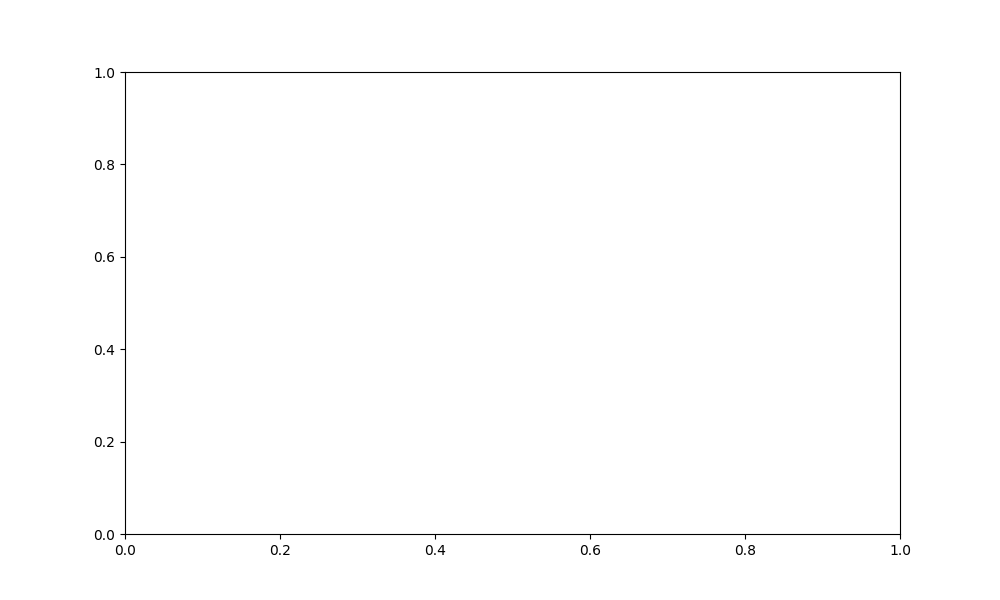

In [40]:
if DATASET == 'synthetic':
    clf.likelihood.update_input_data(grid)
    predictions = clf.gp_model(grid)
    predictions_probs = clf.likelihood(predictions.mean)
    print("STAGE 3")
    predicted_probs = predictions_probs.mean.view(xx1.shape)
    # print (likelihood.cholesky_factor_a.grad)
    print("STAGE 4")
    # psychm_predictions = likelihood(predictions)
    print("STAGE 5")
    # psychm_predicted_probs = likelihood.modified_term.view(xx1.shape)
    # Plot validation predictions in subplots
    num_plots = len([epoch for epoch in validation_predictions.keys() if epoch % EPOCH_BLOCKS == 0])
    cols = 3  # Adjust the number of columns in the subplot grid as needed
    rows = num_plots // cols + (num_plots % cols > 0)

    plot_index = 1

    plt.figure(figsize=(14, rows * 4))
    for i, (epoch, predicted_probs) in enumerate(validation_predictions.items(), 1):
        if epoch % EPOCH_BLOCKS == 0:
            plt.subplot(rows, cols, plot_index)
            # plt.contourf(xx1.numpy(), xx2.numpy(), validation_psych_preds[epoch], cmap=plt.cm.BrBG, alpha=0.9, extend='both', levels=5)
            plt.contourf(xx1.numpy(), xx2.numpy(), predicted_probs, alpha=0.8, cmap=plt.cm.RdYlBu, extend='both', levels=50)
            plt.colorbar(label='Probability of Class 1')
            plt.title(f'Epoch {epoch} Predictions, Validation Loss: {clf.val_loss_list[i]:.3f}')
            # Optional: Add contour lines with hatching for one of the plots
            # CS = plt.contour(xx1.numpy(), xx2.numpy(), validation_psych_preds[epoch], levels=5, colors='k', linewidths=1)
            plt.clabel(CS, inline=1, fontsize=10)
            for collection in CS.collections:
                collection.set_hatch('//')  # Set the hatching pattern
            plot_index += 1  # Increment plot index for the next subplot                
    plt.tight_layout()
    plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(clf.train_loss_list)), clf.train_loss_list, label='Training Loss')
plt.plot(np.arange(len(clf.val_loss_list)), clf.val_loss_list, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# plt.imshow(gp_model.covar_module.M)
# plt.colorbar()

In [ ]:
# plt.imshow(gp_model.covar_module.M)
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors

# # Create a custom colormap with 16 different color values
# cmap = colors.ListedColormap(['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'cyan', 'magenta',
#                               'pink', 'brown', 'gray', 'olive', 'teal', 'navy', 'lime', 'maroon'])

# fig = plt.subplot()
# plt.imshow(gp_model.covar_module.M[:30, :30], cmap=cmap, vmin=-5, vmax=10)
# plt.colorbar()


In [ ]:
# gamma, lambda_, _, _, alpha, beta = real_params

In [ ]:
# real_params

In [ ]:
# print(likelihood.variational_mean_alpha,
# likelihood.variational_mean_beta,
# likelihood.gamma, likelihood.lambda_)

In [ ]:
# fig, ax  = plt.subplots()
# ax.hist(np.asarray(clf.alpha_lis[:, :2]).flatten(), bins=50)
# plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

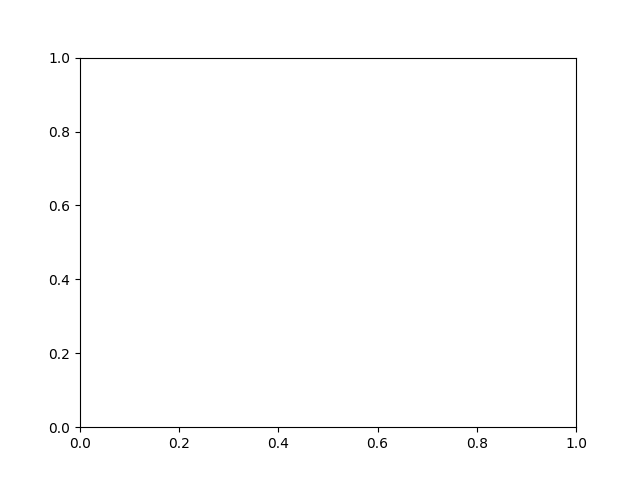

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# Assuming alpha_arr is a numpy array with shape [number_of_alphas, alpha_dimensions]
# where each row is [alpha_0, alpha_1] for that epoch
alpha_arr = np.asarray([alpha.detach().numpy() for alpha in clf.alpha_list])

# Plot the trajectory of alpha values
ax.plot(alpha_arr[:, 0], alpha_arr[:, 1], label='Alpha Trajectory')

# Plot the starting point
ax.plot(alpha_arr[0, 0], alpha_arr[0, 1], marker='o', label='Start')

# Plot the ending point
ax.plot(alpha_arr[-1, 0], alpha_arr[-1, 1], marker='*', label='End')

if DATASET == 'synthetic':
    ax.plot(alpha[0], alpha[1], marker='x', label='True Alpha')    

# Add arrows to show direction
for i in range(len(alpha_arr) - 1):
    # Calculate the change in alpha
    d_alpha = alpha_arr[i + 1] - alpha_arr[i]

    # Add an arrow to the plot
    ax.arrow(alpha_arr[i, 0], alpha_arr[i, 1], d_alpha[0], d_alpha[1],
             head_width=0.02, head_length=0.03, fc='k', ec='k')

# Optionally, set axis labels and a title
ax.set_xlabel('Alpha 0')
ax.set_ylabel('Alpha 1')
ax.set_title('Alpha Trajectory with Direction')

# Add a legend
ax.legend()
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()


In [ ]:
gamma_list = [float(gamma) for gamma in clf.gamma_list]
lambda_list = [float(lambda_) for lambda_ in clf.lambda_list]    


In [ ]:
if clf.train_val_ratio:
    fig, ax = plt.subplots()
    ax.plot(clf.val_auc_list)
    lowest_loss_index = clf.val_loss_list.index(min(clf.val_loss_list))
    lowest_loss_auc = clf.val_auc_list[lowest_loss_index]
    ax.plot(lowest_loss_index, lowest_loss_auc, marker='o', color='red')
    # ax.annotate(f'AUC: {lowest_loss_index:.3f}', (lowest_loss_index, lowest_loss_auc), xytext=(lowest_loss_index, lowest_loss_auc + 0.05), color='red')
    plt.show()

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(lambda_list, label='Lambda')
# plt.show()

In [ ]:
# Plot the trajectory of alpha values
# import torch
gamma_lambda_arr = torch.cat([torch.tensor(clf.gamma_list).view(-1, 1), torch.tensor(clf.lambda_list).view(-1, 1), torch.zeros(len(clf.lambda_list)).view(-1, 1)], dim=1)


In [ ]:
fig, ax = plt.subplots()
ax.plot(gamma_lambda_arr[:, 0], label='Gamma')
ax.set_xlabel('Epoch')
ax.set_ylabel('Gamma')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# Assuming alpha_arr is a numpy array with shape [number_of_alphas, alpha_dimensions]
# where each row is [alpha_0, alpha_1] for that epoch
gamma_lambda_arr = np.asarray(gamma_lambda_arr)

# Plot the trajectory of alpha values
plt.plot(gamma_lambda_arr[:, 0], gamma_lambda_arr[:, 1], label='Alpha Trajectory')

# Plot the starting point
plt.plot(gamma_lambda_arr[0, 0], gamma_lambda_arr[0, 1], marker='o', label='Start')

# Plot the ending point
plt.plot(gamma_lambda_arr[-1, 0], gamma_lambda_arr[-1, 1], marker='*', label='End')

# plt.plot(true_gamma, true_lambda, marker='x', label='True Alpha')    
# Add arrows to show direction
for i in range(len(alpha_arr) - 1):
    # Calculate the change in alpha
    d_gamma_lambda = gamma_lambda_arr[i + 1] - gamma_lambda_arr[i]

    # Add an arrow to the plot
    ax.arrow(gamma_lambda_arr[i, 0], gamma_lambda_arr[i, 1], d_gamma_lambda[0], d_gamma_lambda[1],
             head_width=0.002, head_length=0.004, fc='k', ec='k')

# Optionally, set axis labels and a title
ax.set_xlabel('Gamma')
ax.set_ylabel('Lamnba')
ax.set_title('Alpha Trajectory with Direction')

# Add a legend
ax.legend()
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()


In [ ]:
# torch.exp(likelihood.gamma_var)

In [ ]:
# torch.softmax(torch.stack([likelihood.gamma, likelihood.lambda_, torch.zeros(1)]), axis=0)

In [ ]:
# import LapPUAdapterTF
# clf = LapPUAdapterTF.LapPUAdapterTF(encoder=encoder, 
#                                     gp_kernel_type='rbf', 
#                                     gp_kernel_amplitude=1., 
#                                     gp_kernel_lengthscale=1., 
#                                     estimator_type='logistic', 
#                                     scar_method='elkan', 
#                                     manifold_regularize=True, 
#                                     manifold_kernel_k=64, 
#                                     manifold_kernel_amplitude=2, 
#                                     manifold_kernel_lengthscale=.2, 
#                                     manifold_kernel_power=1, 
#                                     manifold_kernel_noise=0, 
#                                     manifold_neighbor_mode='distance')
# clf.fit(sig_X_train, l_y_cat_transformed_train)

In [ ]:
# from sklearn.utils.validation import check_is_fitted
# check_is_fitted(encoder)

In [ ]:
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from  sklearn.model_selection import GridSearchCV, StratifiedKFold
from skopt.space import Real, Categorical, Integer
import LapPUAdapterTF
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import make_scorer
import logging
logging.basicConfig(level=logging.DEBUG)

def custom_auc_score_function(y_true, y_proba):
    # Compute AUC or similar metric using y_true and predicted probabilities y_proba
    # For example:
    l_true = (y_true // 2).astype(int)
    # logging.warning(f"y_true: {y_true}, l_true: {l_true}, y_proba: {y_proba}")
    # print (l_true, y_proba)
    score = sklearn.metrics.roc_auc_score(l_true, y_proba)  # Assuming binary classification and y_proba is a 2D array
    return score

def custom_brier_score_function(y_true, y_proba):
    # Compute AUC or similar metric using y_true and predicted probabilities y_proba
    # For example:
    l_true = (y_true // 2).astype(int)

    # logging.warning(f"y_true: {y_true}, l_true: {l_true}, y_proba: {y_proba}")
    # print (l_true, y_proba)
    score = sklearn.metrics.brier_score_loss(l_true, y_proba)  # Assuming binary classification and y_proba is a 2D array
    return score


# Create a scorer object that knows it needs probabilities
custom_auc_scorer = make_scorer(custom_auc_score_function, greater_is_better=True, needs_proba=True)
custom_brier_scorer = make_scorer(custom_brier_score_function, greater_is_better=False, needs_proba=True)

    
search_spaces = {
    'gp_kernel_type': Categorical([None]),
    'gp_kernel_amplitude': Real(1e-2, 1e2, prior='log-uniform'),
    # 'gp_kernel_lengthscale': Real(1e-2, 1e2, prior='log-uniform'),
    'manifold_kernel_k': Categorical([16, 32, 64]),
    'manifold_kernel_amplitude': Real(1e-2, 1e2, prior='log-uniform'),
    'manifold_kernel_lengthscale': Real(1e-2, 1e2, prior='log-uniform'),
    'manifold_neighbor_mode': Categorical(['distance']),
    'manifold_regularize': Categorical([True, False]),
    'scar_method': Categorical(['kme']),
    'maxiter': Categorical([10000]),
    'tol': Categorical([1e-8]),
    # You don't need to include the encoder in the search space since it's pre-fitted
}
# grid_params = {
#     'gp_kernel_amplitude': np.logspace(-2, 2, 5),
#     # 'gp_kernel_lengthscale': np.logspace(-2, 2, 10),
#     'scar_method': ['kme'], 'maxiter': [10000],
#     'manifold_kernel_k' :[16, 32, 64],
#     'manifold_kernel_amplitude': np.logspace(-2, 2, 5),
#     'manifold_kernel_lengthscale': np.logspace(-2, 2, 5),
#     'manifold_neighbor_mode': ['distance', 'connectivity'],
#     'manifold_regularize': [True, False],
#     'scar_method': ['kme'],
#     'maxiter': [1000],
#     # 'gp_kernel_type': ['linear'],
#     'tol': [1e-8]}

scar_clf = LapPUAdapterTF.LapPUAdapterTF(estimator_type='logistic',
                                     calibrate=False,
                                    )
cv = StratifiedKFold(n_splits=5)

opt = BayesSearchCV(estimator=scar_clf, search_spaces=search_spaces, n_iter=100, scoring=custom_brier_scorer, n_jobs=-1, cv=cv)
# opt = GridSearchCV(estimator=scar_clf, param_grid=grid_params, scoring=custom_brier_scorer, n_jobs=-1, cv=cv)

# Running the optimization
opt.fit(sig_X_train, l_y_cat_transformed_train)  # No need to pre-transform labels, the pipeline will handle it

# Best parameter set
best_params = opt.best_params_


In [ ]:
print("hd")

In [ ]:
print("ELKAN METHOD NO MANIFOLD:", GP_clf_sckre - sklearn.metrics.roc_auc_score(y_test, opt.best_estimator_.predict_prob_y_given_x(sig_X_test)))

In [ ]:
opt.best_params_

In [ ]:
# OrderedDict([('gp_kernel_amplitude', 0.21700760945795225),
#              ('gp_kernel_lengthscale', 6.5423196395182615),
#              ('gp_kernel_type', None),
#              ('manifold_kernel_amplitude', 10.0),
#              ('manifold_kernel_k', 16),
#              ('manifold_kernel_lengthscale', 0.1),
#              ('manifold_neighbor_mode', 'distance'),
#              ('manifold_regularize', True),
#              ('maxiter', 10000),
#              ('scar_method', 'kme')])

In [ ]:
opt.best_estimator_.estimator


In [ ]:
opt.best_estimator_.scar_method

In [ ]:
from transformers import AutoTokenizer, AutoModel

# For DistilBERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")


In [ ]:
# from transformers import AutoTokenizer, AutoModel

# # Example for BioBERT (replace "bio-bert-model-name" with the actual model name)
# tokenizer = AutoTokenizer.from_pretrained("bio-bert-model-name")
# model = AutoModel.from_pretrained("bio-bert-model-name")